<a href="https://colab.research.google.com/github/Samrajan2919/SAM/blob/master/try_object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os 
 
import numpy as np
import pandas as pd
 
import tensorflow as tf
import tensorflow_hub as th
import matplotlib.pyplot as pl
 
from pprint import pprint as pp
from six import BytesIO as io
from tqdm import tqdm
 
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps

In [ ]:
def pred(img_id, rs) :
    pred_str = []
    
    for i in range(len(rs['detection_scores'])) :
        cn = rs['detection_class_names'][i].decode("utf-8")
        YMin,XMin,YMax,XMax = rs['detection_boxes'][i]
        sc = rs['detection_scores'][i]
        
        pred_str.append(
            f"{cn} {sc} {XMin} {YMin} {XMax} {YMax}"
        )
        
        pred_str = " ".join(pred_str)
        
        return {
        "ImageID": img_id,
        "PredictionString": pred_str,
        'xmin':XMin,
        'ymin'=YMin,
        'xmax':XMax,
        'ymax':YMax,

    }

def display_image(image):
    fig = pl.figure(figsize = (20, 15))
    pl.grid(False)
    pl.axis('off')
    pl.imshow(image)

SyntaxError: ignored

In [ ]:
def bound_bx_img(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness = 4,
                               display_str_list = ()) :
    drw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    drw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width = thickness,
              fill = color)
    
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    
    if top > total_display_str_height:
        txt_bm = top
    else:
        txt_bm = bottom + total_display_str_height
    
    for display_str in display_str_list[::-1]:
        txt_width, txt_height = font.getsize(display_str)
        margin = np.ceil(0.05 * txt_height)
        drw.rectangle([(left, txt_bm - txt_height - 2 * margin),
                        (left + txt_width, txt_bm)],
                       fill = color)
        drw.text((left + margin, txt_bm - txt_height - margin),
                  display_str,
                  fill = "black",
                  font = font)
        txt_bm -= txt_height - 2 * margin

In [ ]:
def draw_boxes(image, bxs, cn, sc, max_boxes = 10, min_score = 0.1):
  
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
            25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(bxs.shape[0], max_boxes)):
        if sc[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(bxs[i].tolist())
            display_str = "{}: {}%".format(cn[i].decode("ascii"),
                                           int(100 * sc[i]))
            
            color = colors[hash(cn[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            
            bound_bx_img(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list = [display_str])
            
            np.copyto(image, np.array(image_pil))
    
    return image

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
sm_img_pth = "/content/test/images/10.jpg"

with tf.Graph().as_default() :
    
    img_str_ph = tf.compat.v1.placeholder(tf.string)
    do_img = tf.image.decode_jpeg(img_str_ph)
    de_img_fl = tf.image.convert_image_dtype(
        image = do_img, dtype = tf.float32)
    
    img_tf = tf.expand_dims(de_img_fl, 0)
    
    mdl_url = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
    dtr = th.Module(mdl_url)
    dtr_ot = dtr(img_tf, as_dict = True)
    
    init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]
    ss = tf.Session()
    ss.run(init_ops)   
    
    with tf.gfile.Open(sm_img_pth, "rb") as bf :
        img_str = bf.read()
        
        rs_ot, img_ot = ss.run(
        [dtr_ot, do_img],
        feed_dict = {img_str_ph: img_str}
    )

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


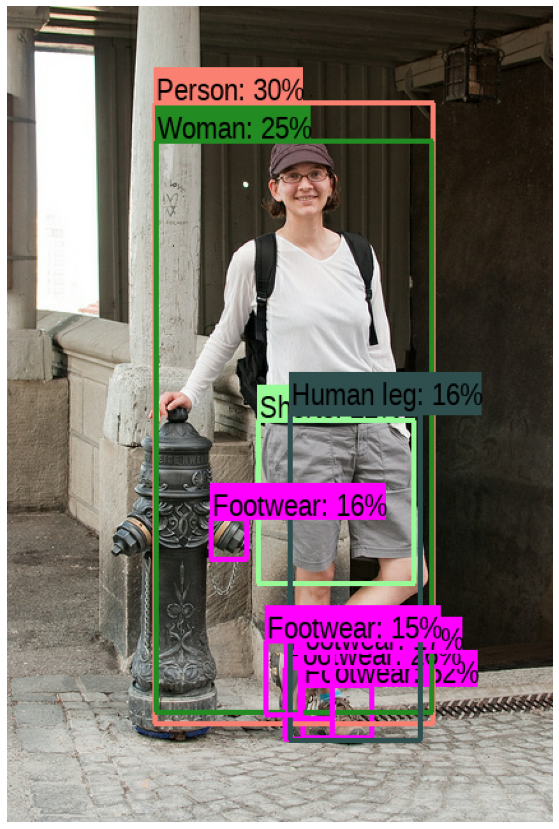

In [ ]:
img_wth_bxs = draw_boxes(
    np.array(img_ot), rs_ot["detection_boxes"],
    rs_ot["detection_class_entities"], rs_ot["detection_scores"]
)
display_image(img_wth_bxs)

In [ ]:
img_str_ph = tf.compat.v1.placeholder(tf.string)
de_img = tf.image.decode_jpeg(img_str_ph)
de_img_fl = tf.image.convert_image_dtype(
    image = de_img, dtype = tf.float32
)
img_ts = tf.expand_dims(de_img_fl, 0)

In [ ]:
print(img_str_ph)
print(de_img)
print(de_img_fl)
print(img_ts)

Tensor("Placeholder_3:0", dtype=string)
Tensor("DecodeJpeg_3:0", shape=(?, ?, ?), dtype=uint8)
Tensor("convert_image_3:0", shape=(?, ?, ?), dtype=float32)
Tensor("ExpandDims_3:0", shape=(1, ?, ?, ?), dtype=float32)


In [ ]:
mdl_url = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
dc = th.Module(mdl_url)
dc_ot = dc(img_ts, as_dict = True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
pprint(dc_ot)

Pretty printing has been turned OFF


In [ ]:
init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]
ss = tf.Session()
ss.run(init_ops)

[None, None]

In [ ]:
g = tf.Graph()
with g.as_default():
    
    c = tf.constant(30.0)
    assert c.graph is g

In [ ]:
with tf.gfile.Open(sm_img_pth, "rb") as bf :
    img_str = bf.read()

rs_ot, img_ot = ss.run(
    [dc_ot, de_img],
    feed_dict = {img_str_ph: img_str}
)

In [ ]:
print("result_out keys:", rs_ot.keys())
print("First 10 detection scores:", rs_ot['detection_scores'][:10])
print()
print("Shape of image_out", img_ot.shape)
print("Type of image_out:", type(img_ot))

result_out keys: dict_keys(['detection_class_labels', 'detection_class_entities', 'detection_class_names', 'detection_boxes', 'detection_scores'])
First 10 detection scores: [0.6267275  0.6022469  0.3061117  0.2650174  0.25867632 0.22079206
 0.17750186 0.16899127 0.16115257 0.15909192]

Shape of image_out (640, 428, 3)
Type of image_out: <class 'numpy.ndarray'>


In [ ]:
sample_submission_df = pd.read_csv('/content/train.csv',
                                   usecols=['filename',
                                            'xmin',
                                            'ymin',
                                            'xmax',
                                            'ymax'])
sample_submission_df.head()



,filename,xmin,ymin,xmax,ymax
0,0.jpg,626.15,243.69,640.00,261.16
1,1.jpg,318.21,194.50,370.43,323.99
2,1500.jpg,61.57,81.75,425.23,502.69
3,3.jpg,441.96,57.22,600.79,219.99
4,4.jpg,416.44,201.57,589.16,418.43


In [ ]:

mg_ids = sm_sub['class']
preds = []

for img_id in tqdm(img_ids):
    
    img_ph = f'/content/test/images/103.jpg'
    with tf.gfile.Open(img_ph, "rb") as bf :
        img_str = bf.read()
    
    rs_ot = ss.run(
        dc_ot,
        feed_dict = {img_str_ph: img_str}
    )
    preds.append(pred(img_id, rs_ot))

ss.close()

100%|██████████| 2161/2161 [10:38<00:00,  3.38it/s]


In [ ]:
submission = pd.DataFrame(preds)
submission.to_csv('submission.csv', index=False)

In [ ]:
!unzip '/content/drive/MyDrive/Big bee/bigthinx_object_detection_hiring_challenge-dataset.zip'

Archive:  /content/drive/MyDrive/Big bee/bigthinx_object_detection_hiring_challenge-dataset.zip
   creating: test/
   creating: test/images/
  inflating: test/images/404.jpg     
  inflating: test/images/302.jpg     
  inflating: test/images/86.jpg      
  inflating: test/images/343.jpg     
  inflating: test/images/41.jpg      
  inflating: test/images/205.jpg     
  inflating: test/images/143.jpg     
  inflating: test/images/45.jpg      
  inflating: test/images/11.jpg      
  inflating: test/images/188.jpg     
  inflating: test/images/395.jpg     
  inflating: test/images/63.jpg      
  inflating: test/images/34.jpg      
  inflating: test/images/277.jpg     
  inflating: test/images/266.jpg     
  inflating: test/images/250.jpg     
  inflating: test/images/133.jpg     
  inflating: test/images/411.jpg     
  inflating: test/images/288.jpg     
  inflating: test/images/23.jpg      
  inflating: test/images/166.jpg     
  inflating: test/images/263.jpg     
  inflating: test/image

In [ ]:
result=pd.read_csv('/content/submission.csv')
result=result.split()

AttributeError: ignored